### Climatelearn testing 

In [ ]:
# This jupyter notebook uses climatelearn tools 
# I use the same data from WeatherBench and compare the results with my implementation of ViT

In [1]:
import sys
print(sys.version)

3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:27:35) [Clang 14.0.6 ]


In [2]:
import torch as T
import torch.nn as nn
#from torchtext import data, datasets
#from torchtext.vocab import Vocab
import torch.optim as optim
import time
import copy
import torch
import torch.nn.functional as F
#from torchsummary import summary
import math

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import dask
import math
import datetime
from collections import OrderedDict


In [3]:
print("Cuda Avaliable :", torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Cuda Avaliable : False
cpu


In [30]:
from climate_learn.utils.data import load_dataset, view

DATADIR = '/Users/noeliaotero/Documents/CAS_ML/WeatherBench-master/data/WeatherBench/5.625deg/'

In [32]:
# Load data module for forecasting task
from climate_learn.utils.datetime import Year, Days, Hours
from climate_learn.data import DataModule

data_module = DataModule(
    dataset = "ERA5",
    task = "forecasting",
    root_dir = DATADIR,
    in_vars = ["2m_temperature"],
    out_vars = ["2m_temperature"],
    train_start_year = Year(2015),
    val_start_year = Year(2016),
    test_start_year = Year(2017),
    end_year = Year(2018),
    pred_range = Days(3),
    subsample = Hours(1),
    batch_size = 128,
    num_workers = 1
)

Creating train dataset


  0%|          | 0/1 [00:00<?, ?it/s]

Creating val dataset


  0%|          | 0/1 [00:00<?, ?it/s]

Creating test dataset


  0%|          | 0/2 [00:00<?, ?it/s]

In [33]:
data_module.train_dataset.time

array(['2015-01-01T00:00:00.000000000', '2015-01-01T01:00:00.000000000',
       '2015-01-01T02:00:00.000000000', ...,
       '2015-12-28T21:00:00.000000000', '2015-12-28T22:00:00.000000000',
       '2015-12-28T23:00:00.000000000'], dtype='datetime64[ns]')

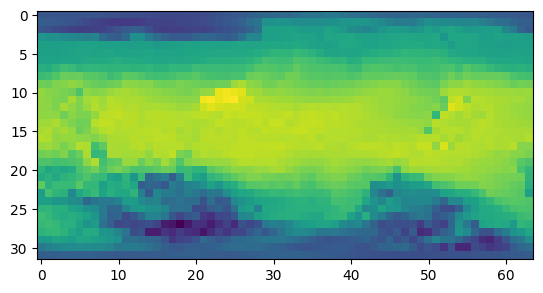

In [35]:
import matplotlib.pyplot as plt
plt.imshow(data_module.train_dataset.inp_data[0,0,:,:])

In [45]:
print(data_module.hparams.in_vars)

['2m_temperature']


In [36]:
from climate_learn.models import load_model

In [62]:
# for ViT
#model_kwargs = {
#     "img_size": [32, 64],
#     "patch_size": 2,
#     "drop_path": 0.1,
#     "drop_rate": 0.1,
#    "in_vars": data_module.hparams.in_vars,
#     "learn_pos_emb": True,
#     "out_vars": data_module.hparams.out_vars,
#     "embed_dim": 128,
#     "depth": 8,
#     "decoder_depth": 0,
#     "num_heads": 4,
#     "mlp_ratio": 4,
# }

# for resnet
model_kwargs = {
    "in_channels": len(data_module.hparams.in_vars),
    "out_channels": len(data_module.hparams.out_vars),
    "n_blocks": 4
}

optim_kwargs = {
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

# model_module = load_model(name = "vit", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
model_module = load_model(name = "resnet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [63]:
model_module.net

ResNet(
  (activation): LeakyReLU(negative_slope=0.3)
  (image_proj): PeriodicConv2D(
    (padding): PeriodicPadding2D()
    (conv): Conv2d(1, 128, kernel_size=(7, 7), stride=(1, 1))
  )
  (blocks): ModuleList(
    (0): ResidualBlock(
      (activation): LeakyReLU(negative_slope=0.3)
      (conv1): PeriodicConv2D(
        (padding): PeriodicPadding2D()
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (conv2): PeriodicConv2D(
        (padding): PeriodicPadding2D()
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (shortcut): Identity()
      (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (1): ResidualBlock(
      (activation): LeakyReLU(negative_slope=0.3)
      (conv1): PeriodicConv2D(
        (padding): PeriodicPadding2D()
        

In [68]:
from climate_learn.training import Trainer, WandbLogger
from rich.progress import track

trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
    # logger = WandbLogger(project = "climate_tutorial", name = "forecast-vit")
)

Global seed set to 0


ModuleNotFoundError: `RichProgressBar` requires `rich` >= 10.2.2. Install it by running `pip install -U rich`.

In [ ]:
# At the moment there are some issues when running some functions of climate_learn, need to check it out! 